In [9]:
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset , DataLoader
import numpy as np
import torch.nn as nn
import os
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [10]:
train_folder_path = "./Dataset_png"
data=[]
target=[]
mean=[0.1973]
std=[0.2371]
to_tensor = transform = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
for number,file_name in enumerate( os.listdir(train_folder_path)):
    file_path=os.path.join(train_folder_path,file_name)
    image=Image.open(file_path)
    image_tensor=to_tensor(image)
    data.append(image_tensor)
    if file_name.startswith("front"):
        target.append(0)
    elif  file_name.startswith("back"):
        target.append(1)
    elif  file_name.startswith("left"):
        target.append(2)
    elif  file_name.startswith("right"):
        target.append(3)
    elif  file_name.startswith("up"):
        target.append(4)
    elif  file_name.startswith("down"):
        target.append(5)

data=torch.stack(data)
target=torch.tensor(target)

In [11]:
dataset = torch.utils.data.TensorDataset(data,target)
train_data, val_data, train_target, val_target = train_test_split(data, target, test_size = 0.2, random_state = 99)
train = torch.utils.data.TensorDataset(train_data,train_target)
val = torch.utils.data.TensorDataset(val_data,val_target)

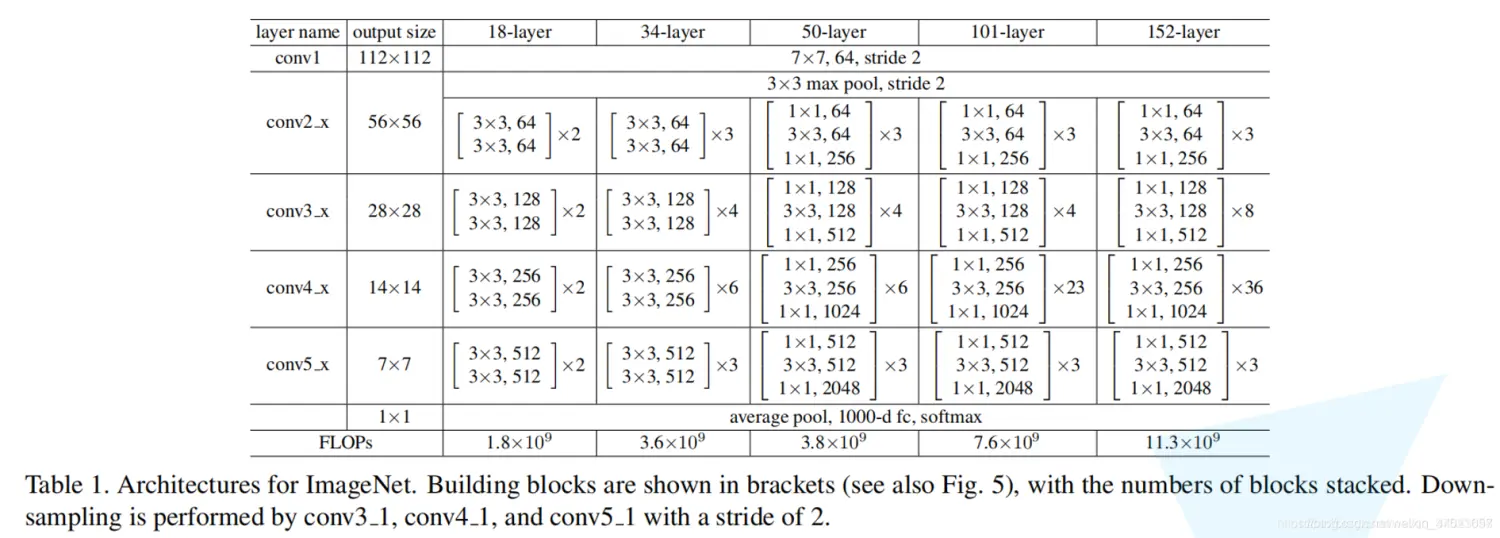

In [12]:
class BasicBlock(nn.Module):
    expansion = 1 #每一个conv的卷积核个数的倍数

    def __init__(self, in_channel, out_channel, stride=1, downsample=None):#downsample对应虚线残差结构
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)#BN处理
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x #捷径上的输出值
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out
class Bottleneck(nn.Module):
    expansion = 4#4倍

    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=1, stride=1, bias=False)  # squeeze channels
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU(inplace=True)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU(inplace=True)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel*self.expansion,#输出*4
                               kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, blocks_num, num_classes=1000, include_top=True):#block残差结构 include_top为了之后搭建更加复杂的网络
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64

        self.conv1 = nn.Conv2d(1, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)自适应
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel, channel))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

        return x
    
def ResNet18(num_classes, include_top=True):
    return ResNet(BasicBlock, [2,2,2,2], num_classes=num_classes, include_top=include_top)

def ResNet34(num_classes, include_top=True):
    return ResNet(BasicBlock, [3,4,6,3], num_classes=num_classes, include_top=include_top)

def ResNet50(num_classes=1000, include_top=True):
    return ResNet(Bottleneck, [3,4,6,3], num_classes=num_classes, include_top=include_top)

def ResNet101(num_classes=1000, include_top=True):
    return ResNet(Bottleneck, [3,4,23,3], num_classes=num_classes, include_top=include_top)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
device="cpu"

cuda:0


In [14]:
batch_size=16
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=0)
validate_loader = torch.utils.data.DataLoader(val,
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=0)

In [15]:
net = ResNet18(num_classes=6)
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
save_path="./high_acc.pth"
epoch=10

In [17]:
train_loss_history=[]
val_loss_history=[]
for i in range(epoch):
    net.train()
    train_loss = 0.0
    k=0
    optimizer.zero_grad()
    for img,target in train_loader:
        predicted=net(img.to(device))
        loss=loss_function(predicted,target.to(device))
        train_loss+=loss
        loss.backward()
        if  (k+1)  % 4 ==  0:  # Wait for several backward passes
            optimizer.step()  # Now we can do an optimizer step
            optimizer.zero_grad()  # Reset gradients to zero
        k+=1
    train_loss=train_loss/len(train)
    train_loss_history.append(train_loss)
    net.eval()
    val_loss = 0.0
    acc=0.0
    for img,target in validate_loader:
        outputs = net(img.to(device))
        loss=loss_function(outputs,target.to(device))
        val_loss+=loss
        predict_y = torch.max(outputs, dim=1)[1]
        acc+=(predict_y==target.to(device)).sum().item()
    val_acc=acc/len(val)
    val_loss=val_loss/len(val)
    val_loss_history.append(val_loss)
    if val_acc > 0.85:
        best_acc = val_acc
        torch.save(net.state_dict(), save_path)
    if i==0 or (i+1)%3==0:
        val_acc=val_acc*100
        print(f"epoch {i+1}, train_loss: {train_loss:.6f}, val_loss: {val_loss:.6f}, accuracy: {val_acc:.2f}%")

print("Done")



    

epoch 1, train_loss: 0.112344, val_loss: 0.109438, accuracy: 22.92%
epoch 3, train_loss: 0.105780, val_loss: 0.103724, accuracy: 31.25%
epoch 6, train_loss: 0.099185, val_loss: 0.094193, accuracy: 40.00%
